# Content-Based Recommender using TF-IDF

In [1]:
from comet_ml import Experiment
experiment = Experiment(api_key="ummagUWZ5eIZzmhPtFkA8oopu")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
[codecarbon INFO @ 10:32:22] [setup] RAM Tracking...
[codecarbon INFO @ 10:32:22] [setup] GPU Tracking...
[codecarbon INFO @ 10:32:22] No GPU found.
[codecarbon INFO @ 10:32:22] [setup] CPU Tracking...
[codecarbon WARNING @ 10:32:22] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 10:32:24] We saw that you have a Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 10:32:24] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 10:32:24] >>> Tracker's metadata:
[codecarbon INFO @ 10:32:24]   Platform system: Linux-5.4.0-147-generic-x86_64-with-glibc2.29
[codecarbon INFO @ 10:32:24]   Python version: 3.8.10
[codecarbon INFO @ 10:32:24]   Available RAM : 31.360 GB
[codecarbon INFO @ 10:3

In [2]:
from tqdm import tqdm
import time

import csv
import numpy as np
import pandas as pd
import scipy.sparse as sp

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity 

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-s33mmr3y because the default path (/home/asadcor/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2023-05-09 10:32:33.775880: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-09 10:32:33.775934: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import re

In [4]:
pdwm = pd.read_csv('working/playlists_dataset_with_mood.csv')

### Data cleaning

In [5]:
pdwm = pdwm.reset_index(drop=True)

mean_popularity = pdwm['track_popularity'].mean()
pdwm.loc[:, 'track_popularity'] = pdwm['track_popularity'].fillna(mean_popularity)

pdwm.loc[:, 'track_explicit'] = pdwm['track_explicit'].fillna(False)

pdwm.loc[:, 'track_explicit'] = pdwm['track_explicit'].astype(int)

pdwm = pdwm.drop(columns=[
    'pos', 'modified_at', 'num_tracks','num_albums','num_followers',
    'num_edits', 'artist_name', 'album_release_date', 'mood',
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'track_popularity', 'track_explicit'
])

In [6]:
pdwm['combined_text'] = pdwm['name'] + ' ' + pdwm['description'].fillna('') + ' ' + pdwm['track_name'] + ' ' + pdwm['album_name']

In [7]:
pattern = r'[^\w\s]|\d|_'
pdwm['combined_text'] = pdwm['combined_text'].apply(lambda x: re.sub(pattern, '', x))

[codecarbon INFO @ 10:32:42] Energy consumed for RAM : 0.000049 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:32:42] Energy consumed for all CPUs : 0.000178 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:32:42] 0.000227 kWh of electricity used since the begining.


In [8]:
pdwm_10k = pdwm.sample(n=70000, random_state=12)

mask = pdwm_10k['pid'].duplicated(keep=False)
pdwm_10k_filtered = pdwm_10k[mask]

# pdwm_10k_filtered = pdwm_10k_filtered.reset_index(drop=True)

pdwm_10k_filtered.shape

(66286, 7)

In [9]:
train, val_test = train_test_split(pdwm_10k_filtered, test_size=0.3, random_state=10, stratify = pdwm_10k_filtered['pid'])

In [10]:
train.head(4)

,pid,name,description,track_name,album_name,track_uri,combined_text
1116413,631853,New beginnings,NaN,Dile Que Tu Me Quieres,Odisea,5u5MvmVtitax9R1Mxh3reC,New beginnings Dile Que Tu Me Quieres Odisea
1136555,694173,Leonard Cohen,NaN,Hallelujah,Sacred Arias,7kyblSqNcOanGyf6KGJwf6,Leonard Cohen Hallelujah Sacred Arias
948225,485267,legend,NaN,All Night Long (All Night) - Single Version,The Definitive Collection,2Wb9ejnmy27DUTUe9YF5Ew,legend All Night Long All Night Single Versi...
323484,146942,Party,NaN,Studio,Oxymoron,29gsi1zZrZxdStACmTQB0Z,Party Studio Oxymoron


In [11]:
pdwm_10k_filtered.isna().sum()

pid                  0
name                 0
description      64944
track_name           0
album_name           0
track_uri            0
combined_text        0
dtype: int64

In [12]:
train = train.reset_index(drop=True)
val_test = val_test.reset_index(drop=True)

### TF-IDF

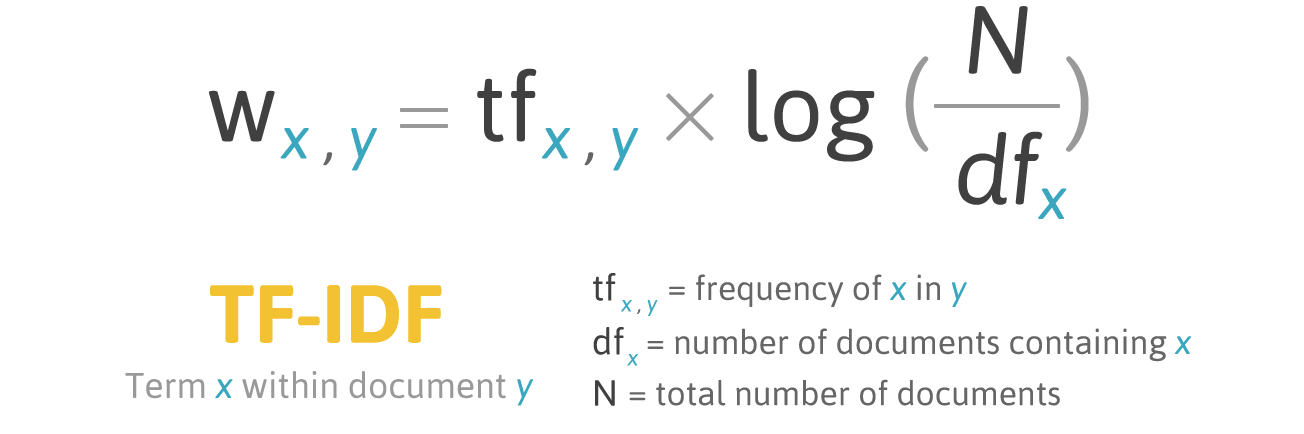

In [13]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(train['combined_text'])

In [14]:
tfidf_matrix.shape

(46400, 120917)

### Cosine Similarity Matrix

In [15]:
train_cos_matrix = linear_kernel(tfidf_matrix, tfidf_matrix)

[codecarbon INFO @ 10:32:57] Energy consumed for RAM : 0.000098 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:32:57] Energy consumed for all CPUs : 0.000354 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:32:57] 0.000452 kWh of electricity used since the begining.


In [16]:
train_cos_matrix.shape

(46400, 46400)

In [17]:
train_cos_matrix

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [18]:
def cos_similar_songs_playlist(cos_matrix, target_playlist_id, cand_list_size):
    """
    Generates a list of cosine-similar songs for a given target playlist.

    Parameters:
        cos_matrix (ndarray): The cosine similarity matrix.
        target_playlist_id (int): The ID of the target playlist.
        cand_list_size (int): The desired size of the candidate song list.

    Returns:
        list: A list of cosine-similar songs.

    """
    target_track_inx = np.where(train["pid"] == target_playlist_id)[0] # index of tracks in training playlist of target playlist
    candidate_cos_matrix = cos_matrix

    ## For each song in the playlist, find k similar songs
    cand_list = []
    # cand_list_size = k*15
    k = np.floor(cand_list_size/len(target_track_inx)) # round(cand_list_size/len(target_track_inx))
    k_rest = cand_list_size - k*len(target_track_inx)
    # e.g., for a candidate list size of 30, get 3 songs for each track first
    for inx, i in enumerate(target_track_inx):
        candidate_song_rec = candidate_cos_matrix[i, ] #ith row of matrix
        candidate_song_rec_inx = np.argsort(candidate_song_rec)
        unique_candidate_song_sorted = train['track_uri'][candidate_song_rec_inx][::-1].drop_duplicates()
        tracks_in_target_playlist = train.loc[train["pid"] == target_playlist_id, "track_uri"]
        song_to_recommend = np.array(unique_candidate_song_sorted.loc[~unique_candidate_song_sorted.isin(tracks_in_target_playlist)])

        if (k_rest != 0 & inx <= k_rest): # 30-24 = 6; for the first 6 tracks recommend k + 1 songs
            k_song_to_recommend = song_to_recommend[:int(k+1)]
        else:
            k_song_to_recommend = song_to_recommend[:int(k)]
            
        if inx == 0:
            cand_list = k_song_to_recommend
        else:
            cand_list = np.append(cand_list, k_song_to_recommend)
    return list(cand_list) # turn np array into list

##  Model Performance Metrics

In [19]:
def nholdout(playlist_id, df):
    """
    Returns the number of songs held out in the validation/test set for a given playlist ID.

    Parameters:
        playlist_id (int): The ID of the playlist.
        df (pandas.DataFrame): The DataFrame containing the playlist data.

    Returns:
        int: The number of songs held out in the validation/test set.

    """
    return len(df[df.pid == playlist_id].track_uri)

In [20]:
def r_precision(predictions, val_set):
    """
    Computes the R-Precision score for a given playlist prediction set.

    Parameters:
        predictions (list or numpy.ndarray): A list or 1-D numpy array containing the predicted track URIs.
        val_set (pandas.Series): A pandas Series representing the ground truth track URIs for the validation set.

    Returns:
        float: The R-Precision score.

    """
    if val_set.shape[0] > 0:
        score = np.sum(val_set.isin(predictions))/val_set.shape[0]
    else:
        score = 0.0
    return score

In [21]:
def dcg_at_k(r, k, method=0):
    """
    Computes the Discounted Cumulative Gain (DCG) at a specified rank `k` given a list of relevance scores.

    Parameters:
        r (list or numpy.ndarray): A list or 1-D numpy array containing the relevance scores.
        k (int): The rank at which to compute the DCG.
        method (int, optional): The formula to use for computing the DCG. 0 for the default formula, 1 for the alternative formula. Default is 0.

    Returns:
        float: The DCG at rank `k`.

    Raises:
        ValueError: If `method` is not 0 or 1.

    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    """
    Computes the Normalized Discounted Cumulative Gain (NDCG) at a specified rank `k` given a list of relevance scores.

    Parameters:
        r (list or numpy.ndarray): A list or 1-D numpy array containing the relevance scores.
        k (int): The rank at which to compute the NDCG.
        method (int, optional): The formula to use for computing the NDCG. 0 for the default formula, 1 for the alternative formula. Default is 0.

    Returns:
        float: The NDCG at rank `k`.

    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [22]:
unique_playlistid = train['pid'].drop_duplicates()

In [23]:
rps = []
ndcgs = []
for pid in unique_playlistid:
    ps = cos_similar_songs_playlist(train_cos_matrix, pid, nholdout(pid, val_test)*15)
    vs = val_test[val_test.pid == pid].track_uri
    rps.append(r_precision(ps, vs))
    
    r = np.zeros(len(ps))
    for i, p in enumerate(ps):
        if np.any(vs.isin([p])):
            r[i] = 1
    ndcgs.append(ndcg_at_k(r, len(r)))

[codecarbon INFO @ 10:33:12] Energy consumed for RAM : 0.000147 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:33:12] Energy consumed for all CPUs : 0.000531 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:33:12] 0.000678 kWh of electricity used since the begining.
[codecarbon INFO @ 10:33:27] Energy consumed for RAM : 0.000196 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:33:27] Energy consumed for all CPUs : 0.000708 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:33:27] 0.000904 kWh of electricity used since the begining.
[codecarbon INFO @ 10:33:42] Energy consumed for RAM : 0.000245 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:33:42] Energy consumed for all CPUs : 0.000885 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:33:42] 0.001130 kWh of electricity used since the begining.
[codecarbon INFO @ 10:33:57] Energy consumed for RAM : 0.000294 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:33:57] Energy consumed for all

[codecarbon INFO @ 10:40:27] Energy consumed for all CPUs : 0.005666 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:40:27] 0.007232 kWh of electricity used since the begining.
[codecarbon INFO @ 10:40:42] Energy consumed for RAM : 0.001616 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:40:42] Energy consumed for all CPUs : 0.005843 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:40:42] 0.007459 kWh of electricity used since the begining.
[codecarbon INFO @ 10:40:57] Energy consumed for RAM : 0.001665 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:40:57] Energy consumed for all CPUs : 0.006020 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:40:57] 0.007685 kWh of electricity used since the begining.
[codecarbon INFO @ 10:41:12] Energy consumed for RAM : 0.001714 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:41:12] Energy consumed for all CPUs : 0.006197 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:41:12] 0.007910 kWh of electricity

[codecarbon INFO @ 10:47:42] 0.013787 kWh of electricity used since the begining.
[codecarbon INFO @ 10:47:57] Energy consumed for RAM : 0.003036 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:47:57] Energy consumed for all CPUs : 0.010978 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:47:57] 0.014013 kWh of electricity used since the begining.
[codecarbon INFO @ 10:48:12] Energy consumed for RAM : 0.003085 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:48:12] Energy consumed for all CPUs : 0.011155 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:48:12] 0.014239 kWh of electricity used since the begining.
[codecarbon INFO @ 10:48:27] Energy consumed for RAM : 0.003134 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:48:27] Energy consumed for all CPUs : 0.011332 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:48:27] 0.014466 kWh of electricity used since the begining.
[codecarbon INFO @ 10:48:42] Energy consumed for RAM : 0.003183 kWh. RAM

In [24]:
avg_rp = np.mean(rps)
avg_ndcg = np.mean(ndcgs)

print('Avg. R-Precision: ', avg_rp)
print('Avg. NDCG: ', avg_ndcg)

print('Total Sum: ', np.mean([avg_rp, avg_ndcg]))

Avg. R-Precision:  0.014743534218295473
Avg. NDCG:  0.009316787007303994
Total Sum:  0.012030160612799733


[codecarbon INFO @ 10:50:12] Energy consumed for RAM : 0.003476 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:50:12] Energy consumed for all CPUs : 0.012571 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:50:12] 0.016047 kWh of electricity used since the begining.
[codecarbon INFO @ 10:50:27] Energy consumed for RAM : 0.003525 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:50:27] Energy consumed for all CPUs : 0.012748 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:50:27] 0.016273 kWh of electricity used since the begining.
[codecarbon INFO @ 10:50:42] Energy consumed for RAM : 0.003574 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:50:42] Energy consumed for all CPUs : 0.012925 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:50:42] 0.016499 kWh of electricity used since the begining.
[codecarbon INFO @ 10:50:57] Energy consumed for RAM : 0.003623 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:50:57] Energy consumed for all

In [25]:
experiment.end()

[codecarbon INFO @ 10:51:33] Energy consumed for RAM : 0.003741 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:51:33] Energy consumed for all CPUs : 0.013528 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:51:33] 0.017270 kWh of electricity used since the begining.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/sadcor/general/5622a3b3bb6c480ea7723921d984d727
COMET INFO:   Parameters:
COMET INFO:     norm         : l2
COMET INFO:     smooth_idf   : True
COMET INFO:     sublinear_tf : False
COMET INFO:     use_idf      : True
COMET INFO:   Uploads:
COMET INFO:     asset               : 1 (701 bytes)
COMET INFO:     environment details : 1
COMET INFO:     filena